In [ ]:
#!pip install flash_attn==2.5.8
#!pip install numpy==1.24.4
#!pip install Pillow==10.3.0
#!pip install Requests==2.31.0
#!pip install torch==2.3.0
#!pip install torchvision==0.18.0
#!pip install transformers==4.40.2
#!pip install accelerate==0.30.1
#!pip install peft==0.11.1
#!pip install datasets==2.19.1

In [ ]:
#!rm -rf models

In [ ]:
import os
import numpy as np
import pandas as pd

import base64
import requests
from PIL import Image
from io import BytesIO

import torch
import transformers
from peft import LoraConfig, get_peft_model, PeftModel

import torch
import torch.nn as nn
import transformers
from peft import LoraConfig, get_peft_model

from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms.functional import resize, to_pil_image
from torchvision import transforms

from datasets import load_dataset

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
torch.manual_seed(3)
base_model_id = "microsoft/Phi-3-vision-128k-instruct"
model_dir = "models/peft_adapter"
os.makedirs(model_dir, exist_ok=True)

# Create datasets as explained in README
train_dataset_path = "boxing_mistakes_chat_train.csv"
val_dataset_path = "boxing_mistakes_chat_val.csv"

In [ ]:
model = transformers.AutoModelForCausalLM.from_pretrained(base_model_id, device_map="cuda", trust_remote_code=True, torch_dtype="auto")

processor = transformers.AutoProcessor.from_pretrained(base_model_id, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
device

device(type='cuda')

In [ ]:
image_url = "https://www.infighting.ca/wp-content/uploads/0011.jpg"

# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

response = requests.get(image_url, headers=headers, stream=True)

if response.status_code == 200:
    try:
        image = Image.open(BytesIO(response.content))
    except Exception as e:
        print(f"Error opening image: {e}")
else:
    print(f"Failed to retrieve image. Status code: {response.status_code}")

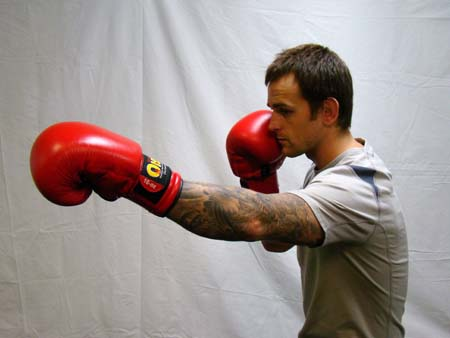

In [ ]:
image

In [ ]:
processor.tokenizer.chat_template

"{% for message in messages %}{{'<|' + message['role'] + '|>' + '\n' + message['content'] + '<|end|>\n' }}{% endfor %}{% if add_generation_prompt and messages[-1]['role'] != 'assistant' %}{{- '<|assistant|>\n' -}}{% endif %}"

In [ ]:
messages = [
    {"role": "user", "content": "<|image_1|>\nWhat boxing or kickboxing mistake is the person making in the picture?"}
]

prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

print(prompt)

<|user|>
<|image_1|>
What boxing or kickboxing mistake is the person making in the picture?<|end|>
<|assistant|>



In [ ]:
inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

In [ ]:
generation_args = {
    "max_new_tokens": 500,
    "temperature": 0.0
}

generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)

generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

print(response)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


The person in the picture is making the mistake of not keeping their fist in a proper boxing or kickboxing stance. They are standing with their fist up, which is not the correct position for throwing a punch or defending against one. In boxing or kickboxing, the fist should be kept down and close to the body, with the elbow tucked in, to generate power and maintain balance. This stance allows for better control, accuracy, and protection of the head and body. The person in the image should adjust their stance to ensure they are ready to throw a punch or defend against one effectively.


The answer is wrong. The person in the picture is wearing gloves, which logically makes their fist appear less tightly closed.
The right answer is low shoulder position.

# Fine-tuning

## Dataset preparation

In [ ]:
df_train = pd.read_csv(train_dataset_path, sep=";")

df_train.head()

,userPrompt,imageURL,assistantResponse
0,What kickboxing mistake is the person making i...,images/image1.jpg,The mistake consists in leaving space between ...
1,What kickboxing mistake is the person making i...,images/image2.jpg,The individual's back foot appears to be too l...
2,What kickboxing mistake is the person making i...,images/image4.jpg,The foot position is correct with proper weigh...
3,What kickboxing mistake is the person making i...,images/image5.jpg,"The stance of the individual is correct, becau..."
4,What kickboxing mistake is the person making i...,images/image6.jpg,"The stance of the individual is correct, becau..."


In [ ]:
df_val = pd.read_csv(val_dataset_path, sep=";")

df_val.head()

,userPrompt,imageURL,assistantResponse
0,What kickboxing mistake is the person making i...,images/image3.jpg,The individual's back foot appears to be too l...
1,What kickboxing mistake is the person making i...,images/image10.jpg,The individual on the right leaves space betwe...
2,What kickboxing mistake is the person making i...,images/image3.jpg,The individual's back foot appears to be too l...
3,What kickboxing mistake is the person making i...,images/image10.jpg,The individual on the right leaves space betwe...
4,What kickboxing mistake is the person making i...,images/image3.jpg,The individual's back foot appears to be too l...


In [ ]:
class FTDataset(Dataset):
    def __init__(self, dataframe, processor, max_length, image_size):
        self.dataframe = dataframe
        self.tokenizer = processor.tokenizer
        self.tokenizer.padding_side = 'left'
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)


    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = f"<|user|>\n<|image_1|>\n{row['userPrompt']}<|end|>\n<|assistant|>\n{row['assistantResponse']}"
        image_path = row['imageURL']

        encodings = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length)

        image = Image.open(image_path) #.convert("RGB")
        image = self.image_transform_function(image)

        encodings['pixel_values'] = image

        return {key: torch.tensor(val) for key, val in encodings.items()}


    def image_transform_function(self, image):
        image = np.array(image)
        return image


    """
    def image_transform_function(self, image):
      transform = transforms.Compose([
          transforms.Resize((224, 224)),  # Resize to the input size expected by your model
          transforms.ToTensor(),          # Convert image to tensor
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize if using pretrained models
      ])
      return transform(image)
    """

In [ ]:
train_dataset = FTDataset(df_train, processor, max_length=512, image_size=128)
val_dataset = FTDataset(df_val, processor, max_length=512, image_size=128)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
print(f"Length of train_dataset: {len(train_dataset)}")
print(f"Length of val_dataset: {len(val_dataset)}")

Length of train_dataset: 96
Length of val_dataset: 10


## Setup LoRA

In [ ]:
model.gradient_checkpointing_enable()

In [ ]:
#list(model.state_dict().keys())

In [ ]:
config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=[
        "self_attn.q_proj.weight",
        "self_attn.k_proj.weight",
        "self_attn.v_proj.weight",
        "self_attn.qkv_proj.weight",
        "self_attn.out_proj.weight",
        "mlp.gate_up_proj",
        "mlp.down_proj",
        "lora_magnitude_vector"
    ],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    use_dora=False
)

peft_model = get_peft_model(model, config)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()

    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 7864320 || all params: 4154485760 || trainable%: 0.18929707439892632


## Training

In [ ]:
class CustomTrainer(transformers.Trainer):
    def compute_loss(self, model, batch, return_outputs=False):
        model = model.float()
        input_ids = batch['input_ids'].to(device).long()
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = input_ids.clone().detach()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            labels=labels
        )
        loss = outputs.loss

        return (loss, outputs) if return_outputs else loss

    def get_train_dataloader(self):
      train_dataset = self.train_dataset
      data_collator = self.data_collator

      dataloader_params = {
          "batch_size": self.args.train_batch_size,
          "collate_fn": data_collator,
          "num_workers": self.args.dataloader_num_workers,
          "pin_memory": self.args.dataloader_pin_memory,
      }

      if not isinstance(train_dataset, torch.utils.data.IterableDataset):
          dataloader_params["sampler"] = self._get_train_sampler()
          dataloader_params["drop_last"] = self.args.dataloader_drop_last

      return DataLoader(train_dataset, **dataloader_params)

    def get_eval_dataloader(self, eval_dataset=None):
      eval_dataset = eval_dataset if eval_dataset is not None else self.eval_dataset
      if eval_dataset is None:
          raise ValueError("Trainer: evaluation requires an eval_dataset.")

      data_collator = self.data_collator

      dataloader_params = {
          "batch_size": self.args.eval_batch_size,
          "collate_fn": data_collator,
          "num_workers": self.args.dataloader_num_workers,
          "pin_memory": self.args.dataloader_pin_memory,
      }

      if not isinstance(eval_dataset, torch.utils.data.IterableDataset):
          dataloader_params["sampler"] = self._get_eval_sampler(eval_dataset)
          dataloader_params["drop_last"] = False

      return DataLoader(eval_dataset, **dataloader_params)

In [ ]:
torch.cuda.set_rng_state(torch.cuda.get_rng_state(), device='cuda')

In [ ]:
trainer = CustomTrainer(
    model=peft_model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=transformers.TrainingArguments(
        num_train_epochs=5,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=8,
        do_eval=True,
        evaluation_strategy="steps",
        eval_steps=10,
        max_grad_norm=1,
        warmup_ratio=0.1,
        fp16=True, #if not using an Ampere architecture (i.e. not using H100, A100, A6000).
        logging_steps=1,
        output_dir="outputs",
        optim="adamw_torch",
        learning_rate=1e-4,
        lr_scheduler_type="constant",
        hub_private_repo=False,
    )
)
peft_model.config.use_cache = False

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
10,5.871300,No log
20,0.275900,No log
30,0.106600,No log
40,0.044300,No log
50,0.020800,No log
60,0.021500,No log


TrainOutput(global_step=60, training_loss=1.8814869466548165, metrics={'train_runtime': 159.9945, 'train_samples_per_second': 3.0, 'train_steps_per_second': 0.375, 'total_flos': 5979922224906240.0, 'train_loss': 1.8814869466548165, 'epoch': 5.0})

In [ ]:
trainer.save_model(model_dir)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
torch.cuda.empty_cache()

# Inference

In [ ]:
def load_with_peft_adapter(base_model_id, model_path, device="cpu", dtype=torch.float32):
    """
        load model via Huggingface AutoTokenizer, AutoModelForCausalLM
    """
    torch.set_default_device(device)

    with torch.device(device):

        model = transformers.AutoModelForCausalLM.from_pretrained(
            base_model_id,
            device_map=device,
            torch_dtype=dtype,
            trust_remote_code=True
        ).eval()

        finetuned_model = PeftModel.from_pretrained(
            model,
            model_path
        ).eval()
        finetuned_model.to(device)
        finetuned_model.config.use_cache = True

        processor = transformers.AutoProcessor.from_pretrained(base_model_id, trust_remote_code=True)

        return finetuned_model, processor

finetuned_model, processor = load_with_peft_adapter(base_model_id, model_dir, device="cuda", dtype="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def run_inference(model, image_path, device="cuda") -> dict:
    try:
        prompt = "<|user|>\n<|image_1|>\nWhat kickboxing mistake is the person making in the picture?<|end|>\n<|assistant|>\n:"

        image = Image.open(image_path)

        inputs = processor(text=prompt, images=[image], return_tensors="pt", padding=True).to(device)

        generation_args = {
            "max_new_tokens": 1000,
            "temperature": 0.0
        }

        from torch.cuda.amp import autocast

        # Use autocast to handle mixed precision automatically during inference or training
        with autocast():
          generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)

        generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
        response_text = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

        return response_text


    except Exception as e:
        print(f"Error during inference: {e}")
        raise

image_path = "images/image1.jpg"
response = run_inference(finetuned_model, image_path, device)
print(response)

The individual on the punching bag is making a common mistake by keeping their back foot too light on the floor, suggesting a lack of proper weight distribution. This can lead to a decrease in power and stability during punches.


In [ ]:
for i, row in df_val.iterrows():
  image_path = row["imageURL"]
  response = run_inference(finetuned_model, image_path, device)
  print(response)
  if i == 1:
    break

The individual on the punching bag is making a common mistake by keeping their back foot too light on the floor, suggesting a lack of proper weight distribution. This can lead to a decrease in power and stability during punches.
<the content of the image does not provide enough information to determine a specific mistake in the person's kickboxing technique>
